In [1]:
#import package we need to use.
import jieba
import json
import requests
import pandas as pd
from datetime import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import sys
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
#引進結巴自訂辭典
jieba.load_userdict('Jieba_Self.txt') 
url = "https://graph.facebook.com/v2.12/"
getKOJpost = 'DoctorKoWJ/posts?fields=message&'
token = 'access_token=EAACEdEose0cBAE89TEZAofMg5L3CKp3mSGkYhW6j4AL78h5i1JvkaVdjZAsxU0bJ9gkz5Sloob51KZAGVIpfZAaMZBQSCm1H2GAYaz93031aQoTkTPMd9nr3sIOvOMm6OAF9Yu4yYwaCKNgjARajeLyhUWKsGfLZCfYLd7RpI10GwB4WKInxerYL5x6DFxKZBtv6h6xwKqhtuvcsECi2t5z'
res = requests.get(url+getKOJpost+token)
#確定可以讀取到網頁
res.status_code

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\User\AppData\Local\Temp\jieba.cache
Loading model cost 1.037 seconds.
Prefix dict has been built succesfully.


200

### 目標 : 以4個月為區間蒐集文章，做從今往前12個月共3個區間的文字雲 

In [2]:
js = json.loads(res.text)
#嘗試取出文章
#其架構為'data'裡儲存文章的list
#list裡的'message'儲存文章 &'id'儲存文章id
text = js['data'][0]['message']
id = js['data'][0]['id']
#從data裡的id到id的頁面，取出文章發布日期，轉換成datatime物件
res_id = requests.get(url+id+'?'+token)
js_id = json.loads(res_id.text)
time = js_id['created_time']
print(time)
#strptime為字串->時間、strftime為時間->字串，需要字串&解讀格式兩引數
str_date = datetime.strptime(time,'%Y-%m-%dT%H:%M:%S+0000')
print(str_date)

2018-03-30T05:30:49+0000
2018-03-30 05:30:49


In [3]:
#觀察json的長相
js
#js裡的['data']儲存文章資料、['paging']['next']儲存下一篇文章的網址

{'data': [{'id': '136845026417486_1281908878577756',
   'message': '不管藍綠統獨及各種社運，臺灣必須成為一個法治的國家。'},
  {'id': '136845026417486_1281264501975527',
   'message': '未來30年，臺灣不可能有三級貧戶當上總統，因為貧富在目前的社會已經世襲。如果一個小朋友沒有網路、手機、電腦，他根本沒有機會和人競爭，這個局面必須打破。\n\n我常說，即使在資本主義的社會裡，有兩項東西要社會主義，一個是醫療，另一個就是教育。臺灣現在已經有健保，醫療平權差不多達到了，但教育平權要努力的空間就很大。\n\n這就是為什麼要推動教育E化，3年內，我們要讓臺北市所有國小、國中、高中全面建立免費網路、E化教室，每一個學生有平板或其它移動載具 （mobile device）。我們已經把每一科的課程都拍成影片上網（臺北酷課雲），還要繼續精進。將來，每一位孩子只要願意學習，都有載具可以連接網路，透過「酷課雲」自我學習。\n\n未來的世界，知識都在網路上，但如果一個小朋友沒有網路、電腦跟手機，學校又不給他這些東西，他要如何與其他人競爭？所以透過網路建立教育平權，是我們很重要的政策。\n\n教育E化計畫，就是要給貧苦的孩子們留下一個翻身的機會。\n\n#教育E化\n#進步價值光榮城市\n臺北市教育局'},
  {'id': '136845026417486_1280219578746686',
   'message': '今天找來北市府兩位「老文青」：文化局鍾永豐局長、小野老師，一起吃午餐，撒花生，聊城南！\n\n#柯Ｐ便當會\n#北市府老文青來了\n#聽說便當也很文青\nTMS 臺北市影視音實驗教育機構'},
  {'id': '136845026417486_1279512518817392',
   'message': '看到這支影片，就想到以前在台大當醫師時，整天都在醫院工作，回到家時小孩子早就睡了，陪伴小孩的工作都交給岳父母。\n\n不過，小孩的成長只有一次，所以如果可以的話，還是盡量抽空陪陪孩子，4月是小朋友的專屬月份，臺北市教育局推出了「兒童月」系列活動，不只有好玩的闖關與園遊會活動，可以帶著小孩從玩樂中學習，還有很多博物館、場館可以免費入場。

In [4]:
#嘗試比較時間
datetime.strptime('2016-03-28','%Y-%m-%d') < datetime.strptime('2016-03-29','%Y-%m-%d')
print(datetime.strptime('2016-03-28','%Y-%m-%d'))

2016-03-28 00:00:00


In [5]:
#找出規定時間內的文章
#把每一個Post和日期變成一個list存在一個大list裡
#因為是以cell為單位，所以需要initial為第一個頁面
js = json.loads(res.text)
article_list = []
#設定Time_flag來決定爬取文章的時間範圍
time_flag = datetime.now()
end_time = datetime.strptime('2017-04-01','%Y-%m-%d')
#條件設定:只要next這個key存在且時間未達目標，則繼續爬取下一頁
#第一層的while是針對每一個包含next的頁面，第二層的for是針對每一個頁面裡的所有文章
while ('next' in js['paging']) and (time_flag > end_time):
    for article in js['data']:
        #把頁面裡文章的id取出來，透過id進入新的頁面取得文章發布時間
        res_id = requests.get(url+article['id']+'?'+token)
        js_id = json.loads(res_id.text)
        time_flag = datetime.strptime(js_id['created_time'],'%Y-%m-%dT%H:%M:%S+0000')
        article_list.append([article['message'],time_flag])
        if time_flag < end_time:
            break
    if time_flag > end_time:
        #把js更新成下一個頁面的網址
        js = json.loads(requests.get(js['paging']['next']).text)
print('End date is '+datetime.strftime(time_flag))
#因為丟請求的頻率太高所已被拒絕存取(我猜的)，但下面看數量認為已經抓的足夠分析了，所以先忽略這個Error

ConnectionError: HTTPSConnectionPool(host='graph.facebook.com', port=443): Max retries exceeded with url: /v2.12/136845026417486_1022657257836254?access_token=EAACEdEose0cBAE89TEZAofMg5L3CKp3mSGkYhW6j4AL78h5i1JvkaVdjZAsxU0bJ9gkz5Sloob51KZAGVIpfZAaMZBQSCm1H2GAYaz93031aQoTkTPMd9nr3sIOvOMm6OAF9Yu4yYwaCKNgjARajeLyhUWKsGfLZCfYLd7RpI10GwB4WKInxerYL5x6DFxKZBtv6h6xwKqhtuvcsECi2t5z (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000001F6311FAE48>: Failed to establish a new connection: [WinError 10061] 無法連線，因為目標電腦拒絕連線。',))

In [6]:
#看抓到幾篇文章
print(len(article_list))

309


In [9]:
#設立一個三個空字典來儲存詞組，依據時間把詞組放進不同字典
seg_dict_1704_1707 = {}
seg_dict_1708_1711 = {}
seg_dict_1712_1803 = {}
for article in article_list:
    if datetime(2017,3,31)<article[1]<datetime(2017,8,1):
        seg_jieba = jieba.cut(article[0]) 
        seg_list = "|".join(seg_jieba).split('|')
        for s in seg_list:
            if not (s in seg_dict_1704_1707.keys()):
                seg_dict_1704_1707[s] = 1
            else:
                seg_dict_1704_1707[s] += 1
    elif datetime(2017,7,31)<article[1]<datetime(2017,12,1):
        seg_jieba = jieba.cut(article[0]) 
        seg_list = "|".join(seg_jieba).split('|')
        for s in seg_list:
            if not (s in seg_dict_1708_1711.keys()):
                seg_dict_1708_1711[s] = 1
            else:
                seg_dict_1708_1711[s] += 1
    elif datetime(2017,11,30)<article[1]<datetime(2018,4,1):
        seg_jieba = jieba.cut(article[0]) 
        seg_list = "|".join(seg_jieba).split('|')
        for s in seg_list:
            if not (s in seg_dict_1712_1803.keys()):
                seg_dict_1712_1803[s] = 1
            else:
                seg_dict_1712_1803[s] += 1

In [11]:
print('From 2018/03-2017/12')
print(len(seg_dict_1712_1803))
print('From 2017/11-2017/08')
print(len(seg_dict_1708_1711))
print('From 2017/07-2017/04')
print(len(seg_dict_1704_1707))

From 2018/03-2017/12
4668
From 2017/11-2017/08
5469
From 2017/07-2017/04
4198


In [12]:
#設定要刪除的詞組
remove_list = [',','。','/','有','在']
for item in remove_list:
    seg_dict_1712_1803.pop(item, None)
    seg_dict_1708_1711.pop(item, None)
    seg_dict_1704_1707.pop(item, None)

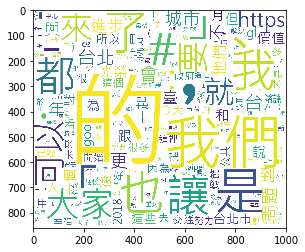

In [13]:
#要把字體設定成中文字體，而且要把中文字體放進wordcloud的路徑裡
wordcloud = WordCloud(font_path = 'msjh.ttc', background_color="white",width=1000, height=860, margin=2)
wordcloud.fit_words(seg_dict_1712_1803)
plt.imshow(wordcloud)
plt.show()

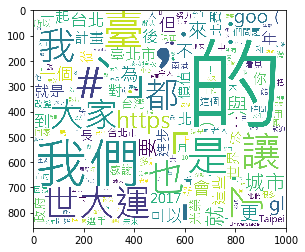

In [14]:
wordcloud = WordCloud(font_path = 'msjh.ttc', background_color="white",width=1000, height=860, margin=2)
wordcloud.fit_words(seg_dict_1708_1711)
plt.imshow(wordcloud)
plt.show()

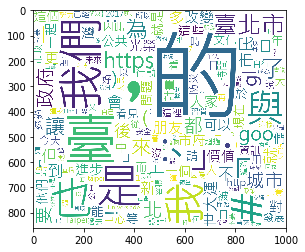

In [15]:
wordcloud = WordCloud(font_path = 'msjh.ttc', background_color="white",width=1000, height=860, margin=2)
wordcloud.fit_words(seg_dict_1704_1707)
plt.imshow(wordcloud)
plt.show()